<a href="https://colab.research.google.com/github/gabriellaaileen/Healthcare-Expert-System/blob/main/Disease_Diagnosis_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Requirements**


In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

import tensorflow as tf
from tensorflow import keras

In [2]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#**Load Dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = pd.read_csv('/content/drive/MyDrive/Project DTS/Dataset/dataset.csv')
description = pd.read_csv('/content/drive/MyDrive/Project DTS/Dataset/symptom_Description.csv')
precaution = pd.read_csv('/content/drive/MyDrive/Project DTS/Dataset/symptom_precaution.csv')
severity = pd.read_csv('/content/drive/MyDrive/Project DTS/Dataset/Symptom-severity.csv')

#**EDA**


##Dataset

In [ ]:
dataset.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     4920 non-null   object
 1   Symptom_1   4920 non-null   object
 2   Symptom_2   4920 non-null   object
 3   Symptom_3   4920 non-null   object
 4   Symptom_4   4572 non-null   object
 5   Symptom_5   3714 non-null   object
 6   Symptom_6   2934 non-null   object
 7   Symptom_7   2268 non-null   object
 8   Symptom_8   1944 non-null   object
 9   Symptom_9   1692 non-null   object
 10  Symptom_10  1512 non-null   object
 11  Symptom_11  1194 non-null   object
 12  Symptom_12  744 non-null    object
 13  Symptom_13  504 non-null    object
 14  Symptom_14  306 non-null    object
 15  Symptom_15  240 non-null    object
 16  Symptom_16  192 non-null    object
 17  Symptom_17  72 non-null     object
dtypes: object(18)
memory usage: 692.0+ KB


In [ ]:
dataset.shape

(4920, 18)

In [ ]:
dataset.describe().transpose()

,count,unique,top,freq
Disease,4920,41,Fungal infection,120
Symptom_1,4920,34,vomiting,822
Symptom_2,4920,48,vomiting,870
Symptom_3,4920,54,fatigue,726
Symptom_4,4572,50,high_fever,378
Symptom_5,3714,38,headache,348
Symptom_6,2934,32,nausea,390
Symptom_7,2268,26,abdominal_pain,264
Symptom_8,1944,21,abdominal_pain,276
Symptom_9,1692,22,yellowing_of_eyes,228


In [ ]:
#Menghitung presentase missing values dari masing-masing variabel
(dataset.isnull().sum()/len(dataset)*100).to_frame('Persentase Missing Value Dataset (%)')

,Persentase Missing Value Dataset (%)
Disease,0.000000
Symptom_1,0.000000
Symptom_2,0.000000
Symptom_3,0.000000
Symptom_4,7.073171
Symptom_5,24.512195
Symptom_6,40.365854
Symptom_7,53.902439
Symptom_8,60.487805
Symptom_9,65.609756


In [ ]:
dataset['Disease'].unique()

array(['Fungal infection', 'Allergy', 'GERD', 'Chronic cholestasis',
       'Drug Reaction', 'Peptic ulcer diseae', 'AIDS', 'Diabetes ',
       'Gastroenteritis', 'Bronchial Asthma', 'Hypertension ', 'Migraine',
       'Cervical spondylosis', 'Paralysis (brain hemorrhage)', 'Jaundice',
       'Malaria', 'Chicken pox', 'Dengue', 'Typhoid', 'hepatitis A',
       'Hepatitis B', 'Hepatitis C', 'Hepatitis D', 'Hepatitis E',
       'Alcoholic hepatitis', 'Tuberculosis', 'Common Cold', 'Pneumonia',
       'Dimorphic hemmorhoids(piles)', 'Heart attack', 'Varicose veins',
       'Hypothyroidism', 'Hyperthyroidism', 'Hypoglycemia',
       'Osteoarthristis', 'Arthritis',
       '(vertigo) Paroymsal  Positional Vertigo', 'Acne',
       'Urinary tract infection', 'Psoriasis', 'Impetigo'], dtype=object)

##Severity

In [82]:
severity.head()

,Symptom,weight
0,itching,1
1,skin_rash,3
2,nodal_skin_eruptions,4
3,continuous_sneezing,4
4,shivering,5


In [ ]:
severity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Symptom  133 non-null    object
 1   weight   133 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [ ]:
severity.shape

(133, 2)

In [ ]:
severity['Symptom'].unique()

array(['itching', 'skin_rash', 'nodal_skin_eruptions',
       'continuous_sneezing', 'shivering', 'chills', 'joint_pain',
       'stomach_pain', 'acidity', 'ulcers_on_tongue', 'muscle_wasting',
       'vomiting', 'burning_micturition', 'spotting_urination', 'fatigue',
       'weight_gain', 'anxiety', 'cold_hands_and_feets', 'mood_swings',
       'weight_loss', 'restlessness', 'lethargy', 'patches_in_throat',
       'irregular_sugar_level', 'cough', 'high_fever', 'sunken_eyes',
       'breathlessness', 'sweating', 'dehydration', 'indigestion',
       'headache', 'yellowish_skin', 'dark_urine', 'nausea',
       'loss_of_appetite', 'pain_behind_the_eyes', 'back_pain',
       'constipation', 'abdominal_pain', 'diarrhoea', 'mild_fever',
       'yellow_urine', 'yellowing_of_eyes', 'acute_liver_failure',
       'fluid_overload', 'swelling_of_stomach', 'swelled_lymph_nodes',
       'malaise', 'blurred_and_distorted_vision', 'phlegm',
       'throat_irritation', 'redness_of_eyes', 'sinus_pressu

##Disease description & precaution

In [ ]:
description.head()

,Disease,Description
0,Drug Reaction,An adverse drug reaction (ADR) is an injury ca...
1,Malaria,An infectious disease caused by protozoan para...
2,Allergy,An allergy is an immune system response to a f...
3,Hypothyroidism,"Hypothyroidism, also called underactive thyroi..."
4,Psoriasis,Psoriasis is a common skin disorder that forms...


In [ ]:
precaution.head()

,Disease,Precaution_1,Precaution_2,Precaution_3,Precaution_4
0,Drug Reaction,stop irritation,consult nearest hospital,stop taking drug,follow up
1,Malaria,Consult nearest hospital,avoid oily food,avoid non veg food,keep mosquitos out
2,Allergy,apply calamine,cover area with bandage,NaN,use ice to compress itching
3,Hypothyroidism,reduce stress,exercise,eat healthy,get proper sleep
4,Psoriasis,wash hands with warm soapy water,stop bleeding using pressure,consult doctor,salt baths


#**Preprocessing**

##General preprocessing

In [5]:
#Menghapus spasi pada kolom symptom dataframe severity dan dataset
severity['Symptom'] = severity['Symptom'].str.replace(' ','')

In [6]:
columns = list(dataset.columns)
columns.remove('Disease')

In [7]:
for col in columns:
    dataset[col] = dataset[col].str.replace(' ', '')

In [8]:
#Imputasi missing values dengan 0
dataset = dataset.fillna(0)
dataset.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic_patches,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic_patches,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Fungal infection,itching,nodal_skin_eruptions,dischromic_patches,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Fungal infection,itching,skin_rash,dischromic_patches,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##Label Encoding


In [9]:
#Label encoding pada disease
disease_list = list(dataset['Disease'].unique())
le = LabelEncoder()
encoded_disease = le.fit_transform(disease_list) 

In [10]:
dictionary={}
for i in range(len(list(le.classes_))):
  dictionary[list(le.classes_)[i]]=i

In [11]:
dictionary

{'(vertigo) Paroymsal  Positional Vertigo': 0,
 'AIDS': 1,
 'Acne': 2,
 'Alcoholic hepatitis': 3,
 'Allergy': 4,
 'Arthritis': 5,
 'Bronchial Asthma': 6,
 'Cervical spondylosis': 7,
 'Chicken pox': 8,
 'Chronic cholestasis': 9,
 'Common Cold': 10,
 'Dengue': 11,
 'Diabetes ': 12,
 'Dimorphic hemmorhoids(piles)': 13,
 'Drug Reaction': 14,
 'Fungal infection': 15,
 'GERD': 16,
 'Gastroenteritis': 17,
 'Heart attack': 18,
 'Hepatitis B': 19,
 'Hepatitis C': 20,
 'Hepatitis D': 21,
 'Hepatitis E': 22,
 'Hypertension ': 23,
 'Hyperthyroidism': 24,
 'Hypoglycemia': 25,
 'Hypothyroidism': 26,
 'Impetigo': 27,
 'Jaundice': 28,
 'Malaria': 29,
 'Migraine': 30,
 'Osteoarthristis': 31,
 'Paralysis (brain hemorrhage)': 32,
 'Peptic ulcer diseae': 33,
 'Pneumonia': 34,
 'Psoriasis': 35,
 'Tuberculosis': 36,
 'Typhoid': 37,
 'Urinary tract infection': 38,
 'Varicose veins': 39,
 'hepatitis A': 40}

In [12]:
symptom_list = list(severity['Symptom'].unique())
symptom_list

['itching',
 'skin_rash',
 'nodal_skin_eruptions',
 'continuous_sneezing',
 'shivering',
 'chills',
 'joint_pain',
 'stomach_pain',
 'acidity',
 'ulcers_on_tongue',
 'muscle_wasting',
 'vomiting',
 'burning_micturition',
 'spotting_urination',
 'fatigue',
 'weight_gain',
 'anxiety',
 'cold_hands_and_feets',
 'mood_swings',
 'weight_loss',
 'restlessness',
 'lethargy',
 'patches_in_throat',
 'irregular_sugar_level',
 'cough',
 'high_fever',
 'sunken_eyes',
 'breathlessness',
 'sweating',
 'dehydration',
 'indigestion',
 'headache',
 'yellowish_skin',
 'dark_urine',
 'nausea',
 'loss_of_appetite',
 'pain_behind_the_eyes',
 'back_pain',
 'constipation',
 'abdominal_pain',
 'diarrhoea',
 'mild_fever',
 'yellow_urine',
 'yellowing_of_eyes',
 'acute_liver_failure',
 'fluid_overload',
 'swelling_of_stomach',
 'swelled_lymph_nodes',
 'malaise',
 'blurred_and_distorted_vision',
 'phlegm',
 'throat_irritation',
 'redness_of_eyes',
 'sinus_pressure',
 'runny_nose',
 'congestion',
 'chest_pain',
 

In [13]:
#Membuat dataset baru dengan kolom gejala
dataset2 = pd.DataFrame(columns = symptom_list)
dataset2['Disease']=dataset['Disease']

In [14]:
row,col=dataset.shape
row, col

(4920, 18)

In [15]:
for i in range (row):
  result = np.isin(symptom_list, list(dataset.drop('Disease',axis=1).iloc[i]))
  for j in range(len(result)):
    if result[j]==True:
      dataset2.loc[i,symptom_list[j]]=1

In [16]:
dataset2.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Disease
0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fungal infection
1,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fungal infection
2,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fungal infection
3,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fungal infection
4,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fungal infection


In [17]:
#Imputasi missing value pada dataset baru dengan 0
dataset2 = dataset2.fillna(0)

#Label encoding pada disease
dataset2 = dataset2.replace(dictionary)
dataset2.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Disease
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15


In [18]:
dataset2.shape

(4920, 133)

##Split dataset

In [19]:
#Split dataset menjadi feature (X) dan label (y)
dataset2.astype(int)
y = dataset2['Disease']
X = dataset2.drop(columns=['Disease'])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [21]:
X_train.shape

(3936, 132)

In [22]:
y_train.shape

(3936,)

In [23]:
X_train

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
613,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4155,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3803,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3321,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3790,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4859,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3264,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1653,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2607,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
y_train

613     19
4155    28
3803    26
3321    15
3790    37
        ..
4859    20
3264    36
1653     4
2607     3
2732    10
Name: Disease, Length: 3936, dtype: int64

#**Build Model**

In [79]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512,input_shape=[132], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(41, activation=tf.nn.softmax)
                                    ])

In [40]:
adam = Adam(learning_rate=0.001)

In [39]:
#Callback
callback = EarlyStopping(
    monitor="accuracy",
    patience=10,
    restore_best_weights=True,
    mode='auto'
)

In [41]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=adam,metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               68096     
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 41)                10537     
                                                                 
Total params: 209,961
Trainable params: 209,961
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = model.fit(X_train, y_train, batch_size=64, epochs=50, callbacks=callback)

Epoch 1/50
62/62 [==============================] - 1s 7ms/step - loss: 3.2905 - accuracy: 0.6631
Epoch 2/50
62/62 [==============================] - 0s 7ms/step - loss: 2.8052 - accuracy: 0.9563
Epoch 3/50
62/62 [==============================] - 0s 6ms/step - loss: 2.7780 - accuracy: 0.9776
Epoch 4/50
62/62 [==============================] - 0s 7ms/step - loss: 2.7559 - accuracy: 1.0000
Epoch 5/50
62/62 [==============================] - 0s 7ms/step - loss: 2.7549 - accuracy: 1.0000
Epoch 6/50
62/62 [==============================] - 0s 6ms/step - loss: 2.7549 - accuracy: 1.0000
Epoch 7/50
62/62 [==============================] - 0s 6ms/step - loss: 2.7548 - accuracy: 1.0000
Epoch 8/50
62/62 [==============================] - 0s 7ms/step - loss: 2.7548 - accuracy: 1.0000
Epoch 9/50
62/62 [==============================] - 0s 7ms/step - loss: 2.7547 - accuracy: 1.0000
Epoch 10/50
62/62 [==============================] - 0s 6ms/step - loss: 2.7547 - accuracy: 1.0000
Epoch 11/50
62/62 [

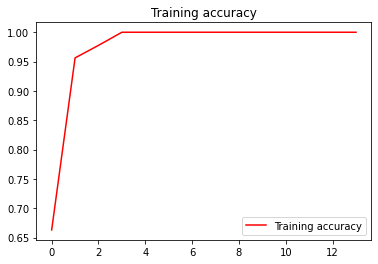

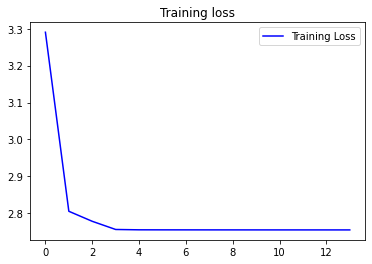

In [46]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.title('Training accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

#**Testing and Evaluate**

In [47]:
X_test.shape

(984, 132)

In [48]:
predictions=[]

In [49]:
for i in range(len(X_test)):
  predictions.append(np.argmax(model.predict(np.array(X_test.iloc[i]).reshape(1,132))))

In [50]:
testing = pd.DataFrame()
testing['Disease'] = y_test
testing['Pred_Disease'] = predictions

testing

,Disease,Pred_Disease
1525,18,18
1013,40,40
1892,36,36
1972,25,25
873,33,33
...,...,...
3871,11,11
1366,32,32
854,9,9
4224,4,4


In [51]:
print(classification_report(testing['Disease'].values, testing['Pred_Disease'].values))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        22
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        23
           5       1.00      1.00      1.00        23
           6       1.00      1.00      1.00        28
           7       1.00      1.00      1.00        27
           8       1.00      1.00      1.00        21
           9       1.00      1.00      1.00        21
          10       1.00      1.00      1.00        34
          11       1.00      1.00      1.00        18
          12       1.00      1.00      1.00        22
          13       1.00      1.00      1.00        27
          14       1.00      1.00      1.00        27
          15       1.00      1.00      1.00        24
          16       1.00      1.00      1.00        27
          17       1.00    

#**Simulation for Expert System**

##**Fill in symptoms**

In [52]:
#@title **Disease Diagnosis**
#@markdown Pilih gejala yang dialami:
#boolean_checkbox = False #@param {type:"boolean"}
gejala_1 = "itching" #@param ["Other", "itching", "skin_rash", "nodal_skin_eruptions", "continuous_sneezing", "shivering", "chills", "joint_pain", "stomach_pain", "acidity", "ulcers_on_tongue", "muscle_wasting", "vomiting", "burning_micturition", "spotting_urination", "fatigue", "weight_gain", "anxiety", "cold_hands_and_feets", "mood_swings", "weight_loss", "restlessness", "lethargy", "patches_in_throat", "irregular_sugar_level", "cough", "high_fever", "sunken_eyes", "breathlessness", "sweating", "dehydration", "indigestion", "headache", "yellowish_skin", "dark_urine", "nausea", "loss_of_appetite", "pain_behind_the_eyes", "back_pain", "constipation", "abdominal_pain", "diarrhoea", "mild_fever", "yellow_urine", "yellowing_of_eyes", "acute_liver_failure", "fluid_overload", "swelling_of_stomach", "swelled_lymph_nodes", "malaise", "blurred_and_distorted_vision", "phlegm", "throat_irritation", "redness_of_eyes", "sinus_pressure", "runny_nose", "congestion", "chest_pain", "weakness_in_limbs", "fast_heart_rate", "pain_during_bowel_movements", "pain_in_anal_region", "bloody_stool", "irritation_in_anus", "neck_pain", "dizziness", "cramps", "bruising", "obesity", "swollen_legs", "swollen_blood_vessels", "puffy_face_and_eyes", "enlarged_thyroid", "brittle_nails", "swollen_extremeties", "excessive_hunger", "extra_marital_contacts", "drying_and_tingling_lips", "slurred_speech", "knee_pain", "hip_joint_pain", "muscle_weakness", "stiff_neck", "swelling_joints", "movement_stiffness", "spinning_movements", "loss_of_balance", "unsteadiness", "weakness_of_one_body_side", "loss_of_smell", "bladder_discomfort", "foul_smell_ofurine", "continuous_feel_of_urine", "passage_of_gases", "internal_itching", "toxic_look_(typhos)", "depression", "irritability", "muscle_pain", "altered_sensorium", "red_spots_over_body", "belly_pain", "abnormal_menstruation", "dischromic_patches", "watering_from_eyes", "increased_appetite", "polyuria", "family_history", "mucoid_sputum", "rusty_sputum", "lack_of_concentration", "visual_disturbances", "receiving_blood_transfusion", "receiving_unsterile_injections", "coma", "stomach_bleeding", "distention_of_abdomen", "history_of_alcohol_consumption", "blood_in_sputum", "prominent_veins_on_calf", "palpitations", "painful_walking", "pus_filled_pimples", "blackheads", "scurring", "skin_peeling", "silver_like_dusting", "small_dents_in_nails", "inflammatory_nails", "blister", "red_sore_around_nose", "yellow_crust_ooze", "prognosis"]
gejala_2 = 'skin_rash' #@param ['Other','itching', 'skin_rash', 'nodal_skin_eruptions','continuous_sneezing', 'shivering', 'chills', 'joint_pain','stomach_pain', 'acidity', 'ulcers_on_tongue', 'muscle_wasting','vomiting', 'burning_micturition', 'spotting_urination','fatigue', 'weight_gain', 'anxiety', 'cold_hands_and_feets','mood_swings', 'weight_loss', 'restlessness', 'lethargy','patches_in_throat', 'irregular_sugar_level', 'cough','high_fever', 'sunken_eyes', 'breathlessness', 'sweating','dehydration', 'indigestion', 'headache', 'yellowish_skin','dark_urine', 'nausea', 'loss_of_appetite','pain_behind_the_eyes', 'back_pain', 'constipation','abdominal_pain', 'diarrhoea', 'mild_fever', 'yellow_urine','yellowing_of_eyes', 'acute_liver_failure', 'fluid_overload','swelling_of_stomach', 'swelled_lymph_nodes', 'malaise','blurred_and_distorted_vision', 'phlegm', 'throat_irritation','redness_of_eyes', 'sinus_pressure', 'runny_nose', 'congestion','chest_pain', 'weakness_in_limbs', 'fast_heart_rate','pain_during_bowel_movements', 'pain_in_anal_region','bloody_stool', 'irritation_in_anus', 'neck_pain', 'dizziness','cramps', 'bruising', 'obesity', 'swollen_legs','swollen_blood_vessels', 'puffy_face_and_eyes','enlarged_thyroid', 'brittle_nails', 'swollen_extremeties','excessive_hunger', 'extra_marital_contacts','drying_and_tingling_lips', 'slurred_speech', 'knee_pain','hip_joint_pain', 'muscle_weakness', 'stiff_neck','swelling_joints', 'movement_stiffness', 'spinning_movements','loss_of_balance', 'unsteadiness', 'weakness_of_one_body_side','loss_of_smell', 'bladder_discomfort', 'foul_smell_ofurine','continuous_feel_of_urine', 'passage_of_gases','internal_itching', 'toxic_look_(typhos)', 'depression','irritability', 'muscle_pain', 'altered_sensorium','red_spots_over_body', 'belly_pain', 'abnormal_menstruation','dischromic_patches', 'watering_from_eyes', 'increased_appetite','polyuria', 'family_history', 'mucoid_sputum', 'rusty_sputum','lack_of_concentration', 'visual_disturbances','receiving_blood_transfusion', 'receiving_unsterile_injections','coma', 'stomach_bleeding', 'distention_of_abdomen','history_of_alcohol_consumption', 'blood_in_sputum','prominent_veins_on_calf', 'palpitations', 'painful_walking','pus_filled_pimples', 'blackheads', 'scurring', 'skin_peeling','silver_like_dusting', 'small_dents_in_nails','inflammatory_nails', 'blister', 'red_sore_around_nose','yellow_crust_ooze', 'prognosis'] {type:"string"}
gejala_3 = 'nodal_skin_eruptions' #@param ['Other','itching', 'skin_rash', 'nodal_skin_eruptions','continuous_sneezing', 'shivering', 'chills', 'joint_pain','stomach_pain', 'acidity', 'ulcers_on_tongue', 'muscle_wasting','vomiting', 'burning_micturition', 'spotting_urination','fatigue', 'weight_gain', 'anxiety', 'cold_hands_and_feets','mood_swings', 'weight_loss', 'restlessness', 'lethargy','patches_in_throat', 'irregular_sugar_level', 'cough','high_fever', 'sunken_eyes', 'breathlessness', 'sweating','dehydration', 'indigestion', 'headache', 'yellowish_skin','dark_urine', 'nausea', 'loss_of_appetite','pain_behind_the_eyes', 'back_pain', 'constipation','abdominal_pain', 'diarrhoea', 'mild_fever', 'yellow_urine','yellowing_of_eyes', 'acute_liver_failure', 'fluid_overload','swelling_of_stomach', 'swelled_lymph_nodes', 'malaise','blurred_and_distorted_vision', 'phlegm', 'throat_irritation','redness_of_eyes', 'sinus_pressure', 'runny_nose', 'congestion','chest_pain', 'weakness_in_limbs', 'fast_heart_rate','pain_during_bowel_movements', 'pain_in_anal_region','bloody_stool', 'irritation_in_anus', 'neck_pain', 'dizziness','cramps', 'bruising', 'obesity', 'swollen_legs','swollen_blood_vessels', 'puffy_face_and_eyes','enlarged_thyroid', 'brittle_nails', 'swollen_extremeties','excessive_hunger', 'extra_marital_contacts','drying_and_tingling_lips', 'slurred_speech', 'knee_pain','hip_joint_pain', 'muscle_weakness', 'stiff_neck','swelling_joints', 'movement_stiffness', 'spinning_movements','loss_of_balance', 'unsteadiness', 'weakness_of_one_body_side','loss_of_smell', 'bladder_discomfort', 'foul_smell_ofurine','continuous_feel_of_urine', 'passage_of_gases','internal_itching', 'toxic_look_(typhos)', 'depression','irritability', 'muscle_pain', 'altered_sensorium','red_spots_over_body', 'belly_pain', 'abnormal_menstruation','dischromic_patches', 'watering_from_eyes', 'increased_appetite','polyuria', 'family_history', 'mucoid_sputum', 'rusty_sputum','lack_of_concentration', 'visual_disturbances','receiving_blood_transfusion', 'receiving_unsterile_injections','coma', 'stomach_bleeding', 'distention_of_abdomen','history_of_alcohol_consumption', 'blood_in_sputum','prominent_veins_on_calf', 'palpitations', 'painful_walking','pus_filled_pimples', 'blackheads', 'scurring', 'skin_peeling','silver_like_dusting', 'small_dents_in_nails','inflammatory_nails', 'blister', 'red_sore_around_nose','yellow_crust_ooze', 'prognosis'] {type:"string"}
gejala_4 = 'continuous_sneezing' #@param ['Other','itching', 'skin_rash', 'nodal_skin_eruptions','continuous_sneezing', 'shivering', 'chills', 'joint_pain','stomach_pain', 'acidity', 'ulcers_on_tongue', 'muscle_wasting','vomiting', 'burning_micturition', 'spotting_urination','fatigue', 'weight_gain', 'anxiety', 'cold_hands_and_feets','mood_swings', 'weight_loss', 'restlessness', 'lethargy','patches_in_throat', 'irregular_sugar_level', 'cough','high_fever', 'sunken_eyes', 'breathlessness', 'sweating','dehydration', 'indigestion', 'headache', 'yellowish_skin','dark_urine', 'nausea', 'loss_of_appetite','pain_behind_the_eyes', 'back_pain', 'constipation','abdominal_pain', 'diarrhoea', 'mild_fever', 'yellow_urine','yellowing_of_eyes', 'acute_liver_failure', 'fluid_overload','swelling_of_stomach', 'swelled_lymph_nodes', 'malaise','blurred_and_distorted_vision', 'phlegm', 'throat_irritation','redness_of_eyes', 'sinus_pressure', 'runny_nose', 'congestion','chest_pain', 'weakness_in_limbs', 'fast_heart_rate','pain_during_bowel_movements', 'pain_in_anal_region','bloody_stool', 'irritation_in_anus', 'neck_pain', 'dizziness','cramps', 'bruising', 'obesity', 'swollen_legs','swollen_blood_vessels', 'puffy_face_and_eyes','enlarged_thyroid', 'brittle_nails', 'swollen_extremeties','excessive_hunger', 'extra_marital_contacts','drying_and_tingling_lips', 'slurred_speech', 'knee_pain','hip_joint_pain', 'muscle_weakness', 'stiff_neck','swelling_joints', 'movement_stiffness', 'spinning_movements','loss_of_balance', 'unsteadiness', 'weakness_of_one_body_side','loss_of_smell', 'bladder_discomfort', 'foul_smell_ofurine','continuous_feel_of_urine', 'passage_of_gases','internal_itching', 'toxic_look_(typhos)', 'depression','irritability', 'muscle_pain', 'altered_sensorium','red_spots_over_body', 'belly_pain', 'abnormal_menstruation','dischromic_patches', 'watering_from_eyes', 'increased_appetite','polyuria', 'family_history', 'mucoid_sputum', 'rusty_sputum','lack_of_concentration', 'visual_disturbances','receiving_blood_transfusion', 'receiving_unsterile_injections','coma', 'stomach_bleeding', 'distention_of_abdomen','history_of_alcohol_consumption', 'blood_in_sputum','prominent_veins_on_calf', 'palpitations', 'painful_walking','pus_filled_pimples', 'blackheads', 'scurring', 'skin_peeling','silver_like_dusting', 'small_dents_in_nails','inflammatory_nails', 'blister', 'red_sore_around_nose','yellow_crust_ooze', 'prognosis'] {type:"string"}
gejala_5 = 'chills' #@param ['Other','itching', 'skin_rash', 'nodal_skin_eruptions','continuous_sneezing', 'shivering', 'chills', 'joint_pain','stomach_pain', 'acidity', 'ulcers_on_tongue', 'muscle_wasting','vomiting', 'burning_micturition', 'spotting_urination','fatigue', 'weight_gain', 'anxiety', 'cold_hands_and_feets','mood_swings', 'weight_loss', 'restlessness', 'lethargy','patches_in_throat', 'irregular_sugar_level', 'cough','high_fever', 'sunken_eyes', 'breathlessness', 'sweating','dehydration', 'indigestion', 'headache', 'yellowish_skin','dark_urine', 'nausea', 'loss_of_appetite','pain_behind_the_eyes', 'back_pain', 'constipation','abdominal_pain', 'diarrhoea', 'mild_fever', 'yellow_urine','yellowing_of_eyes', 'acute_liver_failure', 'fluid_overload','swelling_of_stomach', 'swelled_lymph_nodes', 'malaise','blurred_and_distorted_vision', 'phlegm', 'throat_irritation','redness_of_eyes', 'sinus_pressure', 'runny_nose', 'congestion','chest_pain', 'weakness_in_limbs', 'fast_heart_rate','pain_during_bowel_movements', 'pain_in_anal_region','bloody_stool', 'irritation_in_anus', 'neck_pain', 'dizziness','cramps', 'bruising', 'obesity', 'swollen_legs','swollen_blood_vessels', 'puffy_face_and_eyes','enlarged_thyroid', 'brittle_nails', 'swollen_extremeties','excessive_hunger', 'extra_marital_contacts','drying_and_tingling_lips', 'slurred_speech', 'knee_pain','hip_joint_pain', 'muscle_weakness', 'stiff_neck','swelling_joints', 'movement_stiffness', 'spinning_movements','loss_of_balance', 'unsteadiness', 'weakness_of_one_body_side','loss_of_smell', 'bladder_discomfort', 'foul_smell_ofurine','continuous_feel_of_urine', 'passage_of_gases','internal_itching', 'toxic_look_(typhos)', 'depression','irritability', 'muscle_pain', 'altered_sensorium','red_spots_over_body', 'belly_pain', 'abnormal_menstruation','dischromic_patches', 'watering_from_eyes', 'increased_appetite','polyuria', 'family_history', 'mucoid_sputum', 'rusty_sputum','lack_of_concentration', 'visual_disturbances','receiving_blood_transfusion', 'receiving_unsterile_injections','coma', 'stomach_bleeding', 'distention_of_abdomen','history_of_alcohol_consumption', 'blood_in_sputum','prominent_veins_on_calf', 'palpitations', 'painful_walking','pus_filled_pimples', 'blackheads', 'scurring', 'skin_peeling','silver_like_dusting', 'small_dents_in_nails','inflammatory_nails', 'blister', 'red_sore_around_nose','yellow_crust_ooze', 'prognosis'] {type:"string"}

##**Predict Disease**

In [53]:
symptoms=[gejala_1,gejala_2,gejala_3,gejala_4,gejala_5]
print(symptoms)

['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing', 'chills']


In [54]:
result = np.isin(symptom_list, symptoms)
result=list(result)

In [55]:
for i in range(len(result)):
  if result[i]==True:
    result[i]=1
  else:
    result[i]=0

In [56]:
diagnosis = np.argmax(model.predict(np.array(result).reshape(1,132)))
diagnosis = list(le.classes_)[diagnosis]

In [60]:
disease_description = description[description['Disease']==diagnosis]['Description'].values

In [68]:
disease_description = disease_description[0]

In [65]:
precautions=[]

In [66]:
precautions.append(precaution[precaution['Disease']==diagnosis]['Precaution_1'].values)
precautions.append(precaution[precaution['Disease']==diagnosis]['Precaution_2'].values)
precautions.append(precaution[precaution['Disease']==diagnosis]['Precaution_3'].values)
precautions.append(precaution[precaution['Disease']==diagnosis]['Precaution_4'].values)

In [71]:
print("Here is your diagnosis result!")
print("Disease name: "+diagnosis)
print("Disease description: "+disease_description)
print("Precautions:")
for i in range(4):
  print(str(i+1)+". "+precautions[i][0])

Here is your diagnosis result!
Disease name: Fungal infection
Disease description: In humans, fungal infections occur when an invading fungus takes over an area of the body and is too much for the immune system to handle. Fungi can live in the air, soil, water, and plants. There are also some fungi that live naturally in the human body. Like many microbes, there are helpful fungi and harmful fungi.
Precautions:
1. bath twice
2. use detol or neem in bathing water
3. keep infected area dry
4. use clean cloths
